# Refinamento de uma VLM utilizando o Hugging Face

Utilizaremos a classe SFTTrainer da biblioteca TRL do Hugging Face para refinar um VLM. Este notebook foi adaptado de https://github.com/huggingface/cookbook/blob/main/notebooks/en/fine_tuning_smol_vlm_sft_trl.ipynb

Fato interessante, o construtor da classe de treinamento SFTTrainer possui ~140 parâmetros!


## Dataset

Utilizaremos um conjunto de dados possuindo imagens radiológicas e descrições sobre alterações observadas por especialistas.

In [ ]:
from datasets import load_dataset

dataset_id = "eltorio/ROCOv2-radiology"
ds_train, ds_val, ds_test = load_dataset(
    dataset_id, 
    split=["train[:10%]", "validation[:10%]", "test[:1%]"]
    )

ds_train

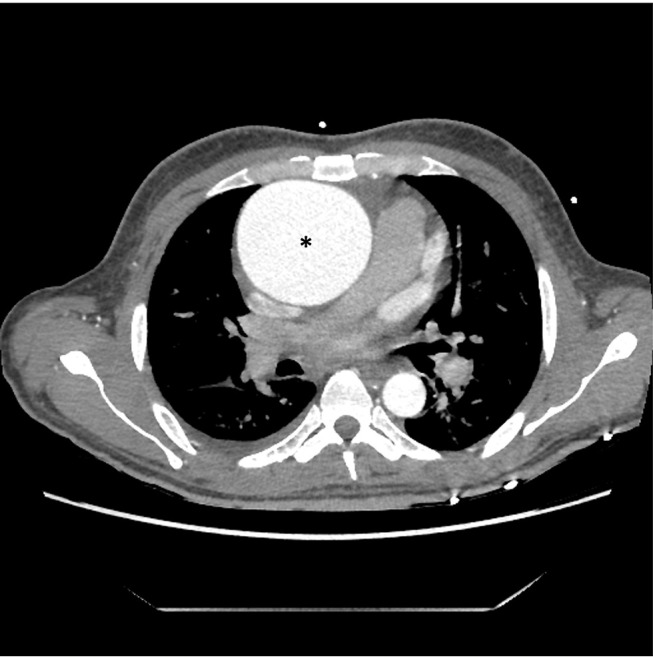

'ROCOv2_2023_test_000001'

'CT chest axial view showing a huge ascending aortic aneurysm (*).'

['C0040405']

In [2]:
display(*ds_test[0].values())

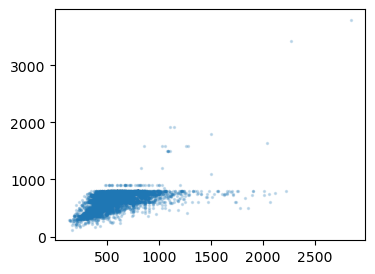

In [3]:
# Visualização dos tamanhos das imagens
import matplotlib.pyplot as plt

def plot_sizes(ds):

    sizes = []
    for sample in ds:
        sizes.append(sample["image"].size)

    h, w = zip(*sizes)
    plt.figure(figsize=(4, 3))
    plt.scatter(w, h, s=2, alpha=0.2)

plot_sizes(ds_train)

Primeiramente, transformaremos todo o dataset no formato de chat esperado pela classe SFTTrainer. Note que esse processo carrega todo o dataset na memória. O ideal seria salvar os dados no disco.

In [4]:
def create_chat(sample):

    instruction = "You are an expert radiographer. Describe accurately what you see in this image."

    chat = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": instruction,
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["caption"]
                }
            ],
        },
    ]

    return chat

ds_train_chat = [create_chat(sample) for sample in ds_train]
ds_val_chat = [create_chat(sample) for sample in ds_val]
ds_test_chat = [create_chat(sample) for sample in ds_test]

In [5]:
ds_train_chat[0]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=682x748>},
   {'type': 'text',
    'text': 'You are an expert radiographer. Describe accurately what you see in this image.'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Head CT demonstrating left parotiditis.'}]}]

## Modelo SmolVLM

Utilizaremos o modelo SmolVLM, que é um modelo otimizado para usar pouca VRAM. O SmolVLM é baseado no modelo Idefics3, por isso utilizamos a classe Idefics3 para carregar o modelo.

In [6]:
import torch
from transformers import BitsAndBytesConfig, Idefics3ForConditionalGeneration, Idefics3Processor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

# Configuração da quantização do modelo
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                    # Utiliza 4 bits por parâmetro
    bnb_4bit_use_double_quant=True,       # Quantiza os coeficientes de quantização
    bnb_4bit_quant_type="nf4",            # Utiliza o formato NF4 para os coeficientes
    bnb_4bit_compute_dtype=torch.bfloat16 # Utiliza bfloat16 para os cálculos. A entrada da camada
                                          # será convertida para bfloat16 antes da multiplicação
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
)
processor = Idefics3Processor.from_pretrained(model_id)

In [7]:
sample = ds_train_chat[0]

full_text = processor.apply_chat_template(
    sample,
)
print(full_text)

<|im_start|>User:<image>You are an expert radiographer. Describe accurately what you see in this image.<end_of_utterance>
Assistant: Head CT demonstrating left parotiditis.<end_of_utterance>



## Aplicação do modelo

Criaremos uma função para facilitar a aplicação do modelo.

'Dado: '

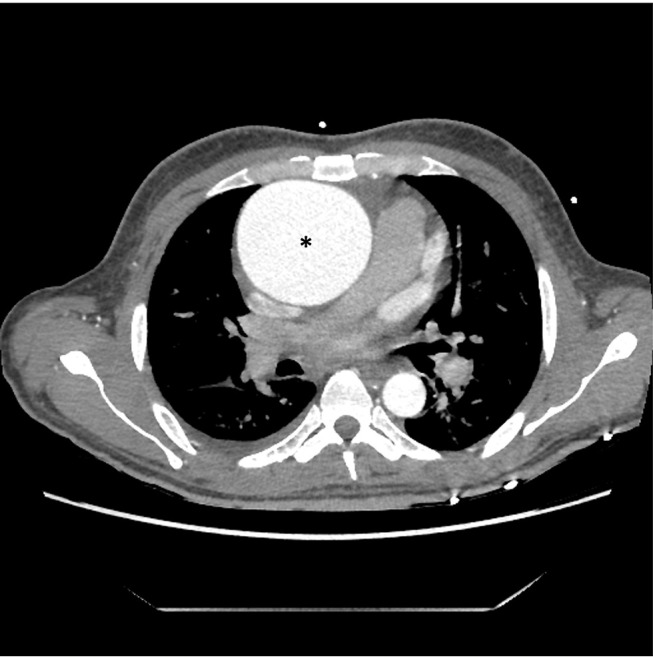

'ROCOv2_2023_test_000001'

'CT chest axial view showing a huge ascending aortic aneurysm (*).'

['C0040405']

'Saída: '

' The image is a black and white axial view of a patient with a contrast-enhanced computed tomography (CT) scan of the chest. The scan shows a large, round, bright, high-intensity area in the right lung parenchyma, which is likely a contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-enhanced contrast-en

In [ ]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=256, device="cuda"):
    """Função que recebe uma amostra do dataset, aplica o modelo e gera o texto de saída."""
    
    # Prepara os dados no formato esperado pelo modelo
    text_input = processor.apply_chat_template(
        sample[:1],  # Importante, remove a resposta esperada
        add_generation_prompt=True
    )

    # Converte a imagem para RGB, formato esperado pelo modelo
    image = sample[0]["content"][0]["image"]
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Tokeniza os dados
    model_inputs = processor(
        text=text_input,
        images=image,
        return_tensors="pt",
    ).to(device)

    # Gera a saída
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Mantém apenas os tokens gerados, removendo os tokens de entrada
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decodifica os tokens
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0] 

idx = 0
output = generate_text_from_sample(model, processor, ds_test_chat[idx])

display("Dado: ", *ds_test[idx].values())
display("Saída: ", output)

## Refinamento do modelo


In [ ]:
# Configuração do adaptador LoRA
from peft import LoraConfig

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["down_proj","o_proj","k_proj","q_proj","gate_proj","up_proj","v_proj"],
    lora_dropout=0.1,
    use_dora=True,
    init_lora_weights="gaussian"
)

In [ ]:
from trl import SFTConfig

gradient_checkpointing = True

if gradient_checkpointing:
    # Cache kv é incompatível com o checkpointing de gradiente
    model.config.use_cache = False

# Evita aviso de que o modelo não possui uma função de loss padrão
model.loss_type = "ForCausalLM"

# Argumentos de treinamento
training_args = SFTConfig(
    output_dir="../data/checkpoints/M11/smolvlm-radiology",
    num_train_epochs=1,
    per_device_train_batch_size=2,   # Batch size por GPU
    gradient_accumulation_steps=8,   # Acumula gradientes. Batchsize efetivo = 2 * 8 = 16
    warmup_steps=50,                 # Warmup do scheduler da taxa de aprendizado
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=5,                 # Log a cada logging_steps passos do gradiente descendente
    save_strategy="steps",
    save_steps=25,                   # Salva o modelo a cada 25 passos do gradiente descendente
    save_total_limit=1,              # Limita o número de checkpoints salvos
    optim="adamw_torch_fused",       # Otimizador AdamW com implementação fused do PyTorch
    bf16=True,
    #report_to="tensorboard",        # É possível armazenar as métricas em diversas plataformas, 
                                     # como TensorBoard, Weights & Biases, etc.
    gradient_checkpointing=gradient_checkpointing,
    label_names=["labels"],          # Nome do campo de rótulos no dataset
    dataloader_num_workers=6,
    # Os parâmetros abaixo são necessários para treinar VLMs, pois a classe SFTTrainer não foi 
    # planejada para VLMs. Ela realiza alguns processamentos que não funcionam para VLMs.
    remove_unused_columns=False,     # Evita de remover informações sobre imagens do dataset
    dataset_text_field="",           
    dataset_kwargs={"skip_prepare_dataset": True},  # Evita de tokenizar o dataset.
)

VLMs não são oficialmente suportados pelo TRL. Para que dados multimodais sejam utilizados, é preciso criar uma collate_fn para gerar batches contendo exatamente qual será a entrada do modelo

In [ ]:
def collate_fn(examples):
    
    # Identifica o índice do token de imagem utilizado pelo tokenizador
    image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

    # Aplica o template de chat para cada exemplo
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    # Identifica as imagens do batch
    image_inputs = []
    for example in examples:
      image = example[0]["content"][0]["image"]
      if image.mode != "RGB":
          image = image.convert("RGB")
      image_inputs.append([image])

    # Tokeniza os dados
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    # Remove tokens de padding do cálculo da loss
    labels[labels == processor.tokenizer.pad_token_id] = -100
    # Remove tokens de imagem do cálculo da loss
    labels[labels == image_token_id] = -100

    batch["labels"] = labels

    return batch

In [8]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_chat,
    eval_dataset=ds_val_chat,
    data_collator=collate_fn,
    processing_class=processor.tokenizer,
    peft_config=peft_config,
)

In [ ]:
# Inicia o treinamento
trainer.train()

In [ ]:
# Salva a versão final do modelo treinado
trainer.save_model("../data/checkpoints/M11/smolvlm-radiology-final")

## Teste do modelo refinado

In [ ]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

# Carrega o modelo base pré-treinado
model_id = "HuggingFaceTB/SmolVLM-Instruct"
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

processor = AutoProcessor.from_pretrained(model_id)

# Carrega o adaptador LoRA treinado
model.load_adapter("../data/checkpoints/M11/smolvlm-radiology-final")

In [8]:
idx = 0
output = generate_text_from_sample(model, processor, ds_test_chat[idx])

output

' CT scan of the chest showing a large mass in the right upper lobe (white asterisk).'